# DESeq 2

## Setting up directory and creating DESeq object

In [60]:
library("DESeq2")
library(ggplot2)
library(ggrepel)
library(scales)
options(repr.plot.width=4, repr.plot.height=3)

In [21]:
setwd("/mnt/storage/r0877717/jupyternotebooks/Task_1")

In [55]:
matrixFile = ("/mnt/storage/r0877717/jupyternotebooks/Task_1/all.gene.counts")
head(matrixFile)

[1] "/mnt/storage/r0877717/jupyternotebooks/Task_1/all.gene.counts"

In [23]:
countData <- as.matrix(read.csv(matrixFile, sep="\t", row.names="Geneid"))
head(countData)

,ctrl1.bam,ctrl2.bam,test1.bam,test2.bam
A430089I19Rik,0,0,0,0
Gm29089,0,0,0,0
1700020D14Rik,0,0,0,0
Zfy1,0,0,0,0
Uba1y,0,0,0,0
Kdm5d,480,365,438,370


In [24]:
countData['Obp2a',] #check the counts for gene Obp2a, they are the same as results from last notebook

ctrl1.bam ctrl2.bam test1.bam test2.bam 
        8        16        66        30

In [25]:
colnames(countData) <- c("Ctrl1","Ctrl2","Test1","Test2") #remove file extension on column names
head(countData)

,Ctrl1,Ctrl2,Test1,Test2
A430089I19Rik,0,0,0,0
Gm29089,0,0,0,0
1700020D14Rik,0,0,0,0
Zfy1,0,0,0,0
Uba1y,0,0,0,0
Kdm5d,480,365,438,370


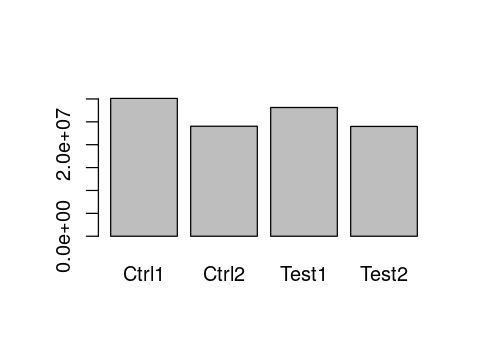

In [26]:
barplot(colSums(countData))

There are more counts in the test1 and ctrl1 groups than the others; the counts need to be normalized.

In [27]:
condition <- factor(c("C","C","T","T"))
print(condition)

[1] C C T T
Levels: C T


In [28]:
colData <- data.frame(sampleName = colnames(countData),condition=condition)
colData #conditions match the sample types

sampleName,condition
<fct>,<fct>
Ctrl1,C
Ctrl2,C
Test1,T
Test2,T


Create DESeq object from variables created above:

In [29]:
dds <- DESeqDataSetFromMatrix(countData = countData,
                              colData = colData,
                              design = ~ condition)

colnames(dds) <- colnames(countData)
dds

class: DESeqDataSet 
dim: 25239 4 
metadata(1): version
assays(1): counts
rownames(25239): A430089I19Rik Gm29089 ... Csf2ra Pisd-ps3
rowData names(0):
colnames(4): Ctrl1 Ctrl2 Test1 Test2
colData names(2): sampleName condition

Some checks on DESeq object:
 - the first dimension of the object is equal to the total gene count
 - the order of the conditions is correct

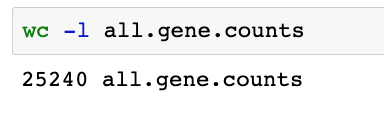

This is the total gene count + 1 for header from the all.gene.counts file. The output pasted here is from the first notebook. This (25240-1=25239) matches the first dimension in dds object.

In [30]:
dds$condition #the order is still correct

[1] C C T T
Levels: C T

## Run the differential expression

In [31]:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## QC

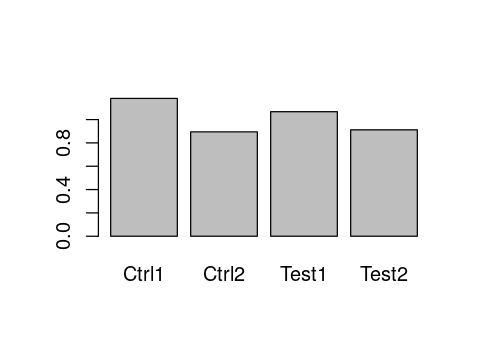

In [32]:
options(repr.plot.width=4, repr.plot.height=3)
barplot(sizeFactors(dds))

Scatter plot:

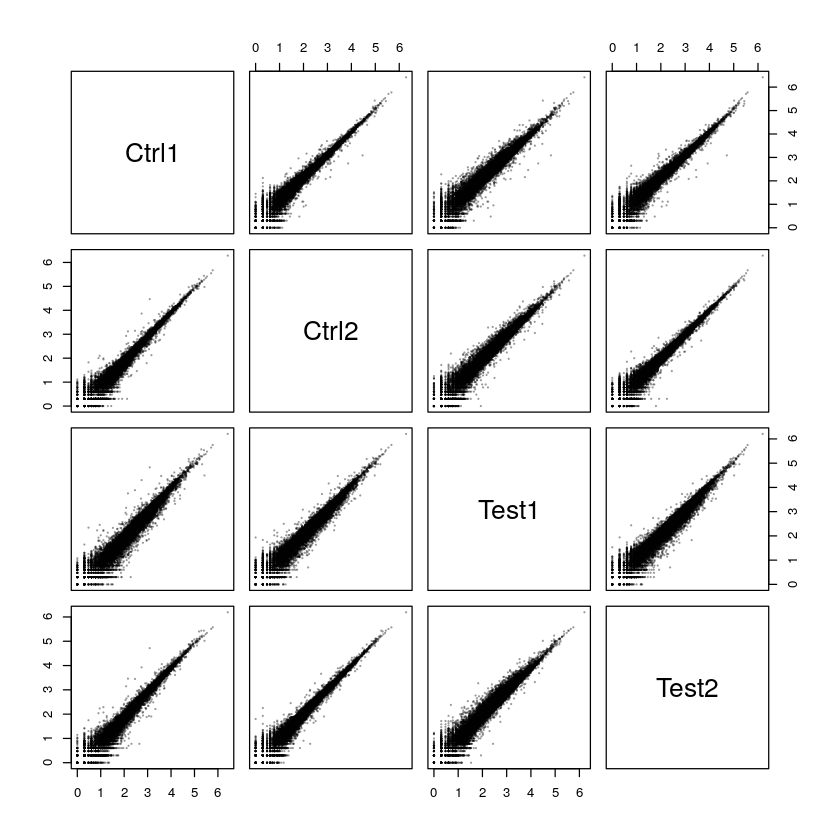

In [139]:
options(repr.plot.width=7, repr.plot.height=7)
plot(data.frame(log10(counts(dds))), cex=0.1, col=alpha("black", 0.4))

Here we see scatter plots of the counts after they have been normalized. The paired samples correlate well (rep1 and rep2). It also looks like the test and control samples pair well together, which is susprising. The replicates of the test conditions do not seem any more similar to each other than to the control samples. This means that there is not a big difference in gene expression between the test and control samples, and that only a few genes will likely be differentially expressed. 

PCA: 

In [62]:
vsd <- vst(dds,blind=FALSE)

class: DESeqDataSet 
dim: 6 4 
metadata(1): version
assays(4): counts mu H cooks
rownames(6): A430089I19Rik Gm29089 ... Uba1y Kdm5d
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(4): Ctrl1 Ctrl2 Test1 Test2
colData names(3): sampleName condition sizeFactor

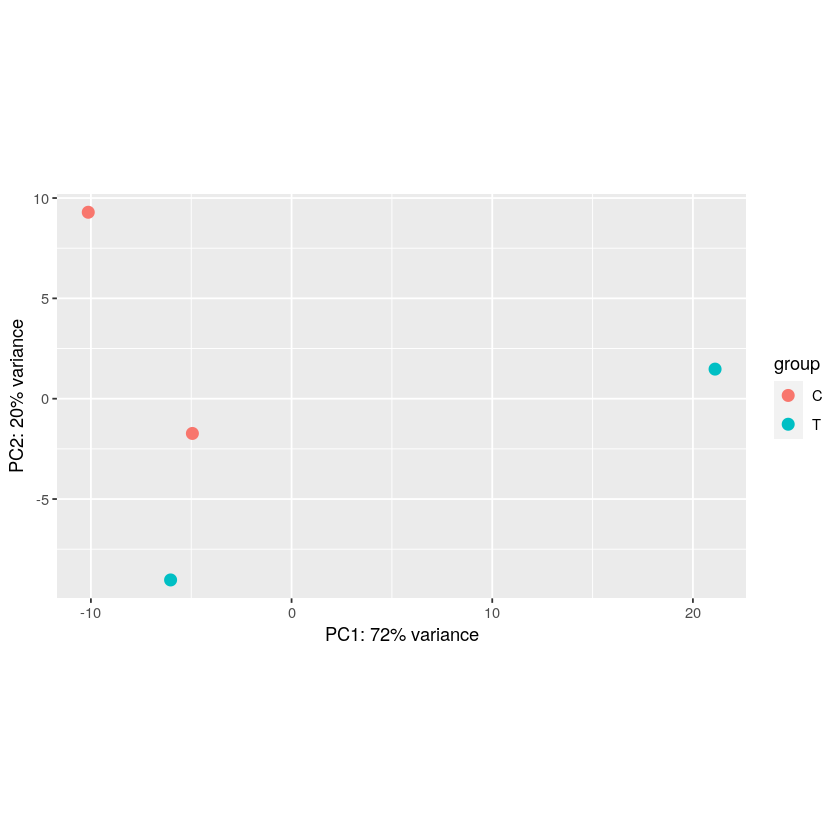

In [140]:
options(repr.plot.width=7, repr.plot.height=7)
plotPCA(vsd, intgroup=c("condition"))

Clustering doesn't look very good for the groups -- this follows what was seen in the scatter plot, it seems like the differences between groups is not much greater than the differences within groups.

Make an MA plot:

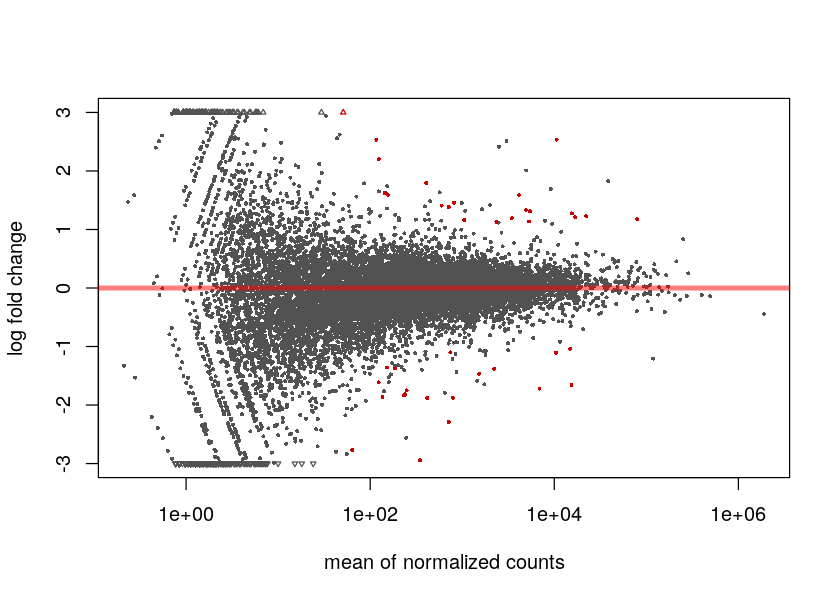

In [142]:
options(repr.plot.width=7, repr.plot.height=5)
plotMA(dds,ylim=c(-3,3))

We see only a few significantly upregulated or downregulated genes (red points), which explains why the groups are not very different from each other in scatterplot and PCA.

Volcano plot:

In [155]:
res <- results(dds, contrast = c("condition", "T", "C"))

Warning message:
“Removed 13326 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 25224 rows containing missing values (`geom_text()`).”


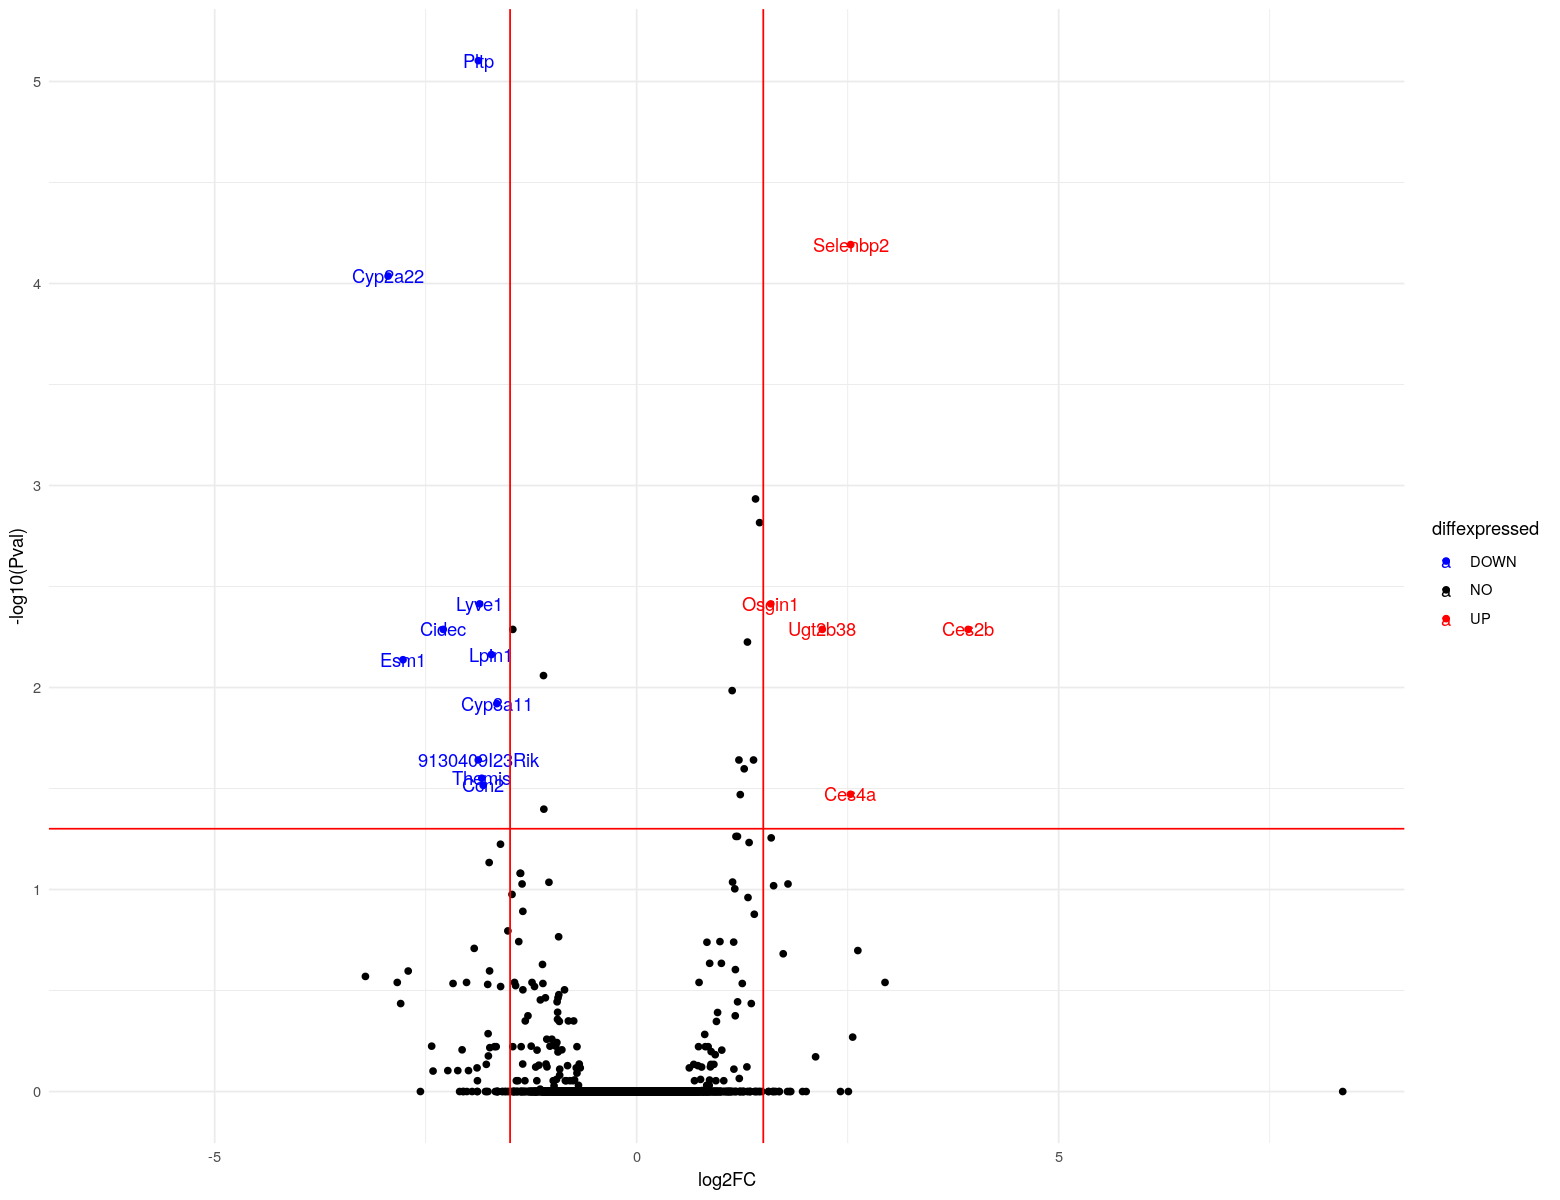

In [158]:
options(repr.plot.width=13, repr.plot.height=10)
data_volcano <- data.frame(log2FC=res$log2FoldChange,Pval=res$padj,gene=row.names(res))
#N/As will get value "NO"
data_volcano$diffexpressed <- "NO"
#genes that are up-regulated
data_volcano$diffexpressed[data_volcano$log2FC > 1.5 & data_volcano$Pval< 0.05] <- "UP"
#genes that are down-regulated
data_volcano$diffexpressed[data_volcano$log2FC < -1.5 & data_volcano$Pval < 0.05] <- "DOWN"
#create label of gene name for each point
data_volcano$gene[data_volcano$diffexpressed == "NO"] <- NA

p <- ggplot(data=data_volcano, aes(x=log2FC, y=-log10(Pval),col=diffexpressed,label=gene))+geom_point()+theme_minimal()+geom_text()
p2 <- p + geom_vline(xintercept=c(-1.5,1.5),col="red") + geom_hline(yintercept=-log10(0.05),col="red")
p3 <- p2 + scale_color_manual(values=c("blue", "black", "red"))
p3


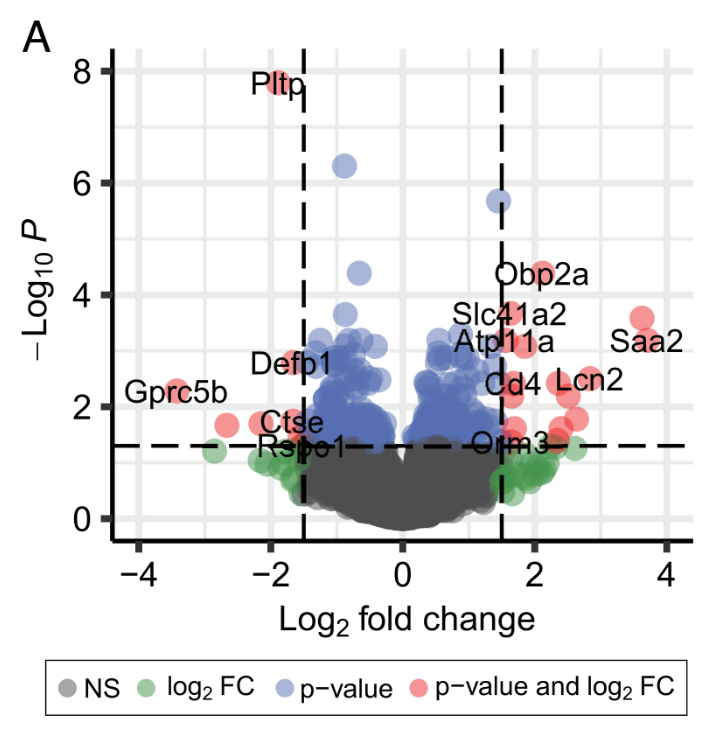

I made a volcano plot to compare it with the one from the paper; Pltp is similarily down-regulated in both. However, most of the genes do not match between the two. 

Export the results:

In [37]:
res <- results(dds)
res <- res[order(res$padj),]
head(res)

log2 fold change (MLE): condition T vs C 
Wald test p-value: condition T vs C 
DataFrame with 6 rows and 6 columns
                 baseMean    log2FoldChange             lfcSE              stat
                <numeric>         <numeric>         <numeric>         <numeric>
Pltp     788.193849107822 -1.87567519803683  0.30375605639859 -6.17493925973138
Selenbp2  10603.361012217  2.53587449359263 0.443480588073312  5.71811836141387
Cyp2a22  348.413632145765 -2.94520308688446 0.527173693734995 -5.58677931369806
Slc41a2  595.551811220306  1.40838733374297 0.277614028722559    5.073185026793
Id3        813.6067010813  1.45648742857059 0.292553281101243  4.97853732177611
Lyve1    136.070171433875 -1.86069620937518 0.393530949339408 -4.72820806723993
                       pvalue                 padj
                    <numeric>            <numeric>
Pltp     6.61889119359884e-10  7.8850850789343e-06
Selenbp2 1.07710108582218e-08 6.41575261769982e-05
Cyp2a22  2.31319371737654e-08 9.185692251

How many genes are differentially expressed? 

In [136]:
res.sign <- res[(!is.na(res$padj)) & (res$padj < 0.05),]
dim(res.sign)

[1] 26  6

Not many genes are differentially expressed. List the DEGs:

In [137]:
print(row.names(res.sign))

 [1] "Rgs16"         "9130409I23Rik" "Pltp"          "Selenbp2"     
 [5] "Orm1"          "Id3"           "Ugt2b38"       "Cyp3a11"      
 [9] "Cidec"         "Cyp2a22"       "Lyve1"         "Ces2b"        
[13] "Ces4a"         "Nudt7"         "Osgin1"        "Ccn2"         
[17] "Themis"        "Slc41a2"       "Egfr"          "Lpin1"        
[21] "Atxn1"         "Esm1"          "Dusp1"         "Plin4"        
[25] "Lipg"          "Gstp1"        


Look at the distribution of pvalues: 

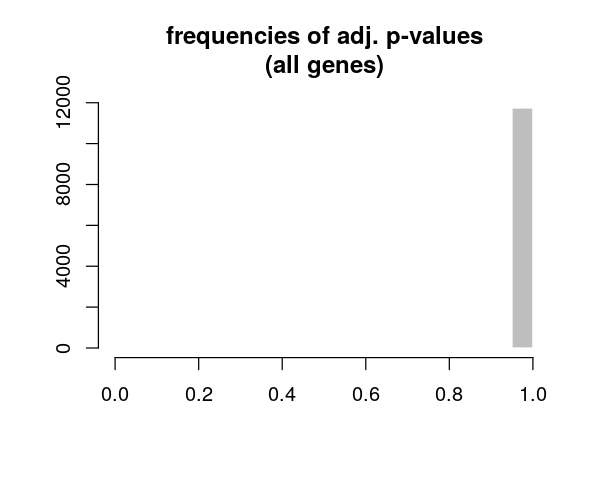

In [39]:
hist(res$padj, 
     col="grey", border="white", xlab="", ylab="", main="frequencies of adj. p-values\n(all genes)")


There are only a few genes that are differentially expressed, and so it makes sense that the vast majority of p-values are non-significant. 

Looking at a few genes mentioned in the paper:
The Obp2a gene is not significant when using padj value. I only used 2 replicates out of 6 which could account for the difference.

log2 fold change (MLE): condition T vs C 
Wald test p-value: condition T vs C 
DataFrame with 1 row and 6 columns
            baseMean   log2FoldChange             lfcSE             stat
           <numeric>        <numeric>         <numeric>        <numeric>
Obp2a 29.83642398056 1.96549329460971 0.809024608125226 2.42946045753095
                 pvalue              padj
              <numeric>         <numeric>
Obp2a 0.015121314293379 0.999740530349781

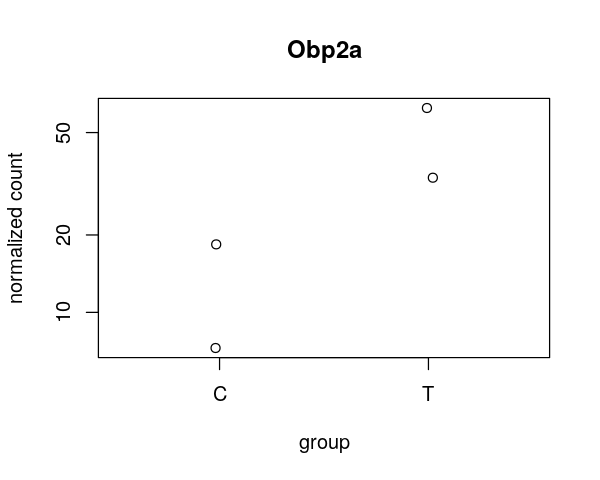

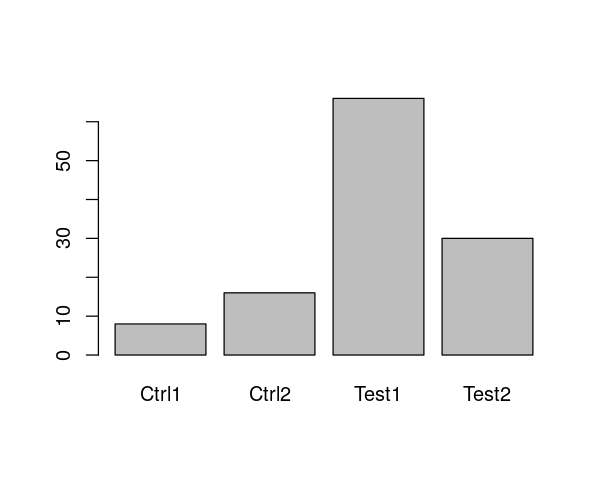

In [52]:
#Gene expected to be differentially regulated from paper
res['Obp2a',]
plotCounts(dds, gene="Obp2a", normalized = TRUE)  
barplot(counts(dds)["Obp2a",])

From looking at the volcano plots, the down-regulation of Pltp is similar to what is seen in the paper. This gene is is involved in phospholipid transfer. 

log2 fold change (MLE): condition T vs C 
Wald test p-value: condition T vs C 
DataFrame with 1 row and 6 columns
             baseMean    log2FoldChange            lfcSE              stat
            <numeric>         <numeric>        <numeric>         <numeric>
Pltp 788.193849107822 -1.87567519803683 0.30375605639859 -6.17493925973138
                   pvalue                padj
                <numeric>           <numeric>
Pltp 6.61889119359884e-10 7.8850850789343e-06

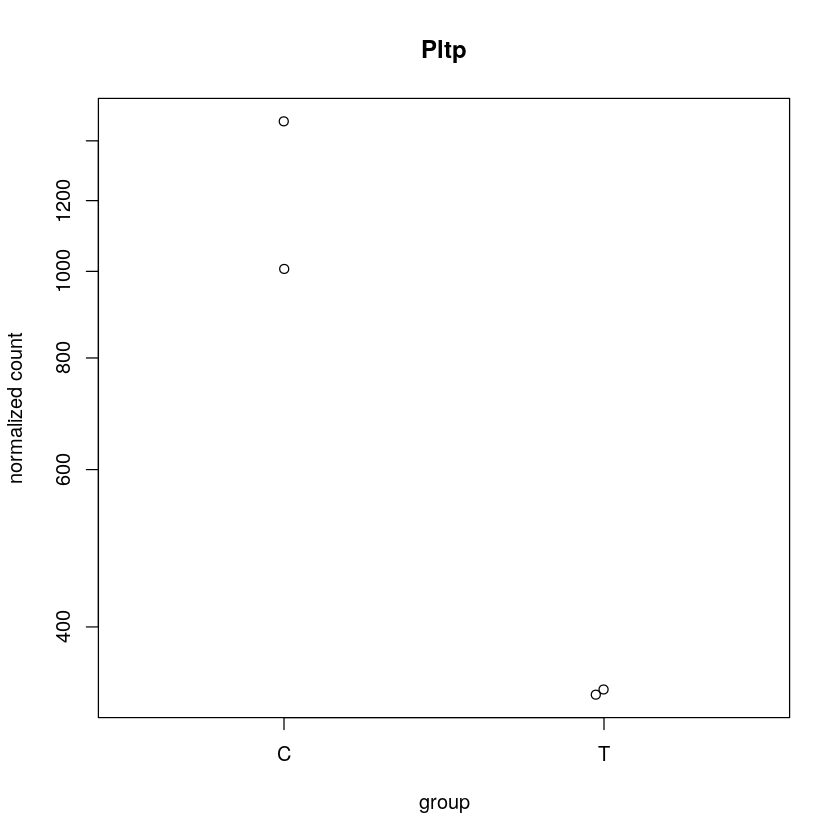

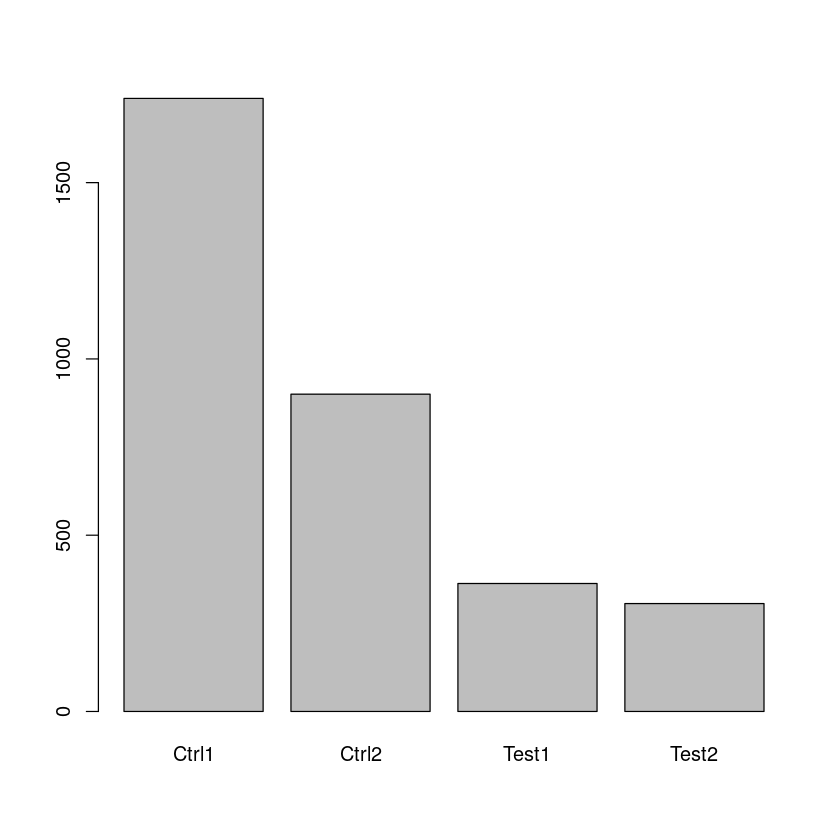

In [144]:
res['Pltp',]
plotCounts(dds, gene="Pltp", normalized = TRUE)  
barplot(counts(dds)["Pltp",])

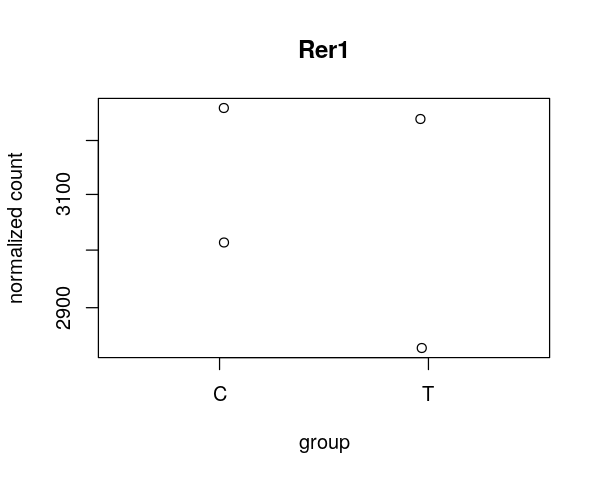

In [53]:
#Mouse housekeeping gene
plotCounts(dds, gene="Rer1", normalized = TRUE)  

A known housekeeping gene, Rer1, has a somewhat stable expression regardless of treatment group.

Save to disk:

In [43]:
write.table(res, "deseq.results.tsv", sep="\t", col.names=NA, quote=FALSE)

In [46]:
res.sorted <- res[order(res$padj),]
head(res.sorted)

log2 fold change (MLE): condition T vs C 
Wald test p-value: condition T vs C 
DataFrame with 6 rows and 6 columns
                 baseMean    log2FoldChange             lfcSE              stat
                <numeric>         <numeric>         <numeric>         <numeric>
Pltp     788.193849107822 -1.87567519803683  0.30375605639859 -6.17493925973138
Selenbp2  10603.361012217  2.53587449359263 0.443480588073312  5.71811836141387
Cyp2a22  348.413632145765 -2.94520308688446 0.527173693734995 -5.58677931369806
Slc41a2  595.551811220306  1.40838733374297 0.277614028722559    5.073185026793
Id3        813.6067010813  1.45648742857059 0.292553281101243  4.97853732177611
Lyve1    136.070171433875 -1.86069620937518 0.393530949339408 -4.72820806723993
                       pvalue                 padj
                    <numeric>            <numeric>
Pltp     6.61889119359884e-10  7.8850850789343e-06
Selenbp2 1.07710108582218e-08 6.41575261769982e-05
Cyp2a22  2.31319371737654e-08 9.185692251